# Style Transfer with OpenVINO™

This notebook demonstrates style transfer with OpenVINO, using the Style Transfer Models from [ONNX Model Repository](https://github.com/onnx/models), specifically [Fast Neural Style Transfer](https://github.com/onnx/models/tree/master/vision/style_transfer/fast_neural_style) model is one of the style transfer models designed to mix the content of an image with the style of another image. 

This notebook uses five pre-trained models, for the following styles: Mosaic, Rain Princess, Candy, Udnie and Pointilism. The models are from the [ONNX Model Repository](https://github.com/onnx/models) and are based on the research paper [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155) along with [Instance Normalization](https://arxiv.org/abs/1607.08022). Final part of this notebook shows live inference results from a webcam. Additionally, you can also upload a video file.

> **NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a server, the webcam will not work. However, you can still do inference on a video.

## Imports

In [2]:
import collections
import sys
import time

import cv2
import numpy as np
from pathlib import Path
from IPython.display import Markdown as md
from IPython import display
from ipywidgets import interactive, ToggleButtons
from openvino.runtime import Core

sys.path.append("../utils")
import notebook_utils as utils

Select one of the styles: Mosaic, Rain Princess, Candy, Udnie and Pointilism.

In [37]:
def print_choices(option):
    """
    Select the preferred style to transferred
    """
    
    
styleButtons = ToggleButtons(
                             options=['MOSAIC', 'RAIN-PRINCESS', 'CANDY', 'UDNIE', 'POINTILISM'],
                             description="Click on the Style:",
                             disabled=False,
                             style={'description_width': '300px'}
                            )
   
interactive(lambda option: print(option), option=styleButtons)

interactive(children=(ToggleButtons(description='Click on the Style:', options=('MOSAIC', 'RAIN-PRINCESS', 'CA…

## The Model

### Download the Model

Model for the selected style will be downloaded to `base_model_dir` if they have not been downloaded before. The selected model comes from the ONNX Model Zoo, which means it must be converted into OpenVINO Intermediate Representation (OpenVINO IR).

In [38]:
# Directory to download the model from ONNX model zoo
base_model_dir = "model"
base_url = "https://github.com/onnx/models/raw/main/vision/style_transfer/fast_neural_style/model"

# Selected ONNX model will be downloaded in the path
model_path = Path(f"{styleButtons.value.lower()}-9.onnx")

style_url = f"{base_url}/{model_path}"
utils.download_file(style_url, directory=base_model_dir)

model\udnie-9.onnx:   0%|          | 0.00/6.42M [00:00<?, ?B/s]

WindowsPath('C:/Intel/GitHub/Clone/2022/openvino_notebooks_Anisha/notebooks/404-style-transfer-webcam/model/udnie-9.onnx')

### Convert ONNX Model to OpenVINO IR Format

Use Model Optimizer to convert the ONNX model to OpenVINO IR with `FP16` precision. The models are saved to the current directory. With these options, it is not necessary to normalize input data before propagating it through the network.
Every conversion should take up to 2 minutes. If the model has been already converted, this step is skipped.

For more information about Model Optimizer, see the [Model Optimizer Developer Guide](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html).

In [39]:
# Construct the command for Model Optimizer.
precision = "FP16"

mo_command = f"""mo
                 --input_model "model/{(styleButtons.value).lower()}-9.onnx"
                 --data_type {precision}
                 --output_dir "{base_model_dir}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert the ONNX model to OpenVINO:")
md(f"`{mo_command}`")

Model Optimizer command to convert the ONNX model to OpenVINO:


`mo --input_model "model/udnie-9.onnx" --data_type FP32 --output_dir "model"`

In [40]:
# Converted IR model path
ir_path = Path(f"model/{(styleButtons.value).lower()}-9.xml")

if not ir_path.exists():
    print("Exporting ONNX model to IR... This may take a few minutes.")
    mo_result = %sx $mo_command
    print("\n".join(mo_result))
else:
    print(f"IR model {ir_path} already exists.")

Exporting ONNX model to IR... This may take a few minutes.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	C:\Intel\GitHub\Clone\2022\openvino_notebooks_Anisha\notebooks\404-style-transfer-webcam\model/udnie-9.onnx
	- Path for generated IR: 	C:\Intel\GitHub\Clone\2022\openvino_notebooks_Anisha\notebooks\404-style-transfer-webcam\model
	- IR output name: 	udnie-9
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	Fa

### Load the Model

Downloaded models are located in a fixed structure, which indicates a vendor (intel or public), the name of the model and a precision.

Only a few lines of code are required to run the model. First, initialize OpenVINO Runtime. Then, read the network architecture and model weights from the `.bin` and `.xml` files to compile for the desired device. If you choose `GPU` you need to wait for a while, as the startup time is much longer than in the case of `CPU`.

There is a possibility to allow OpenVINO to decide which hardware offers the best performance. In that case, just use `AUTO`. Remember that for most cases the best hardware is `GPU` (better performance, but longer startup time).

In [41]:
# Initialize OpenVINO Runtime.
ie_core = Core()
# Read the network and corresponding weights from a file.
model = ie_core.read_model(model=ir_path)
# Compile the model for CPU (you can choose manually CPU, GPU, MYRIAD etc.)
# or let the engine choose the best available device (AUTO).
compiled_model = ie_core.compile_model(model=model, device_name="AUTO")

# Get the input and output nodes.
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

Input and output layers have the names of the input node and output node respectively. In the case of fast-neural-style-mosaic-onnx , there is 1 input and 1 output with shape (1, 3, 224, 224).

In [42]:
print(input_layer.any_name, output_layer.any_name)
print(input_layer.shape)
print(output_layer.shape)

# Get the input size.
N, C, H, W = list(input_layer.shape)

input1 output1
{1, 3, 224, 224}
{1, 3, 224, 224}


### Preprocess the image
Preprocess the input image before running the model

In [43]:
# Preprocess the input image.
def preprocess_images(frame, H, W):
    image = np.array(frame).astype('float32')
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(src=image, dsize=(H, W), interpolation=cv2.INTER_AREA)
    image = np.transpose(image, [2, 0, 1])
    image = np.expand_dims(image, axis=0)
    return image

### Helper function to postprocess the stylized image
The converted IR model outputs a NumPy float32 array of shape [1, 3, 224, 224].

In [44]:
# Postprocess the result        
def convert_result_to_image(frame, stylized_image) -> np.ndarray:
    """
    Resize the styled image to original size
    Convert network result of floating point numbers to image with integer
    """
    h, w = frame.shape[:2]
    stylized_image = stylized_image.squeeze().transpose(1, 2, 0)
    stylized_image = cv2.resize(src=stylized_image, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
    stylized_image = np.clip(stylized_image, 0, 255).astype(np.uint8)
    stylized_image = cv2.cvtColor(stylized_image, cv2.COLOR_BGR2RGB)
    return stylized_image

### Main Processing Function

Running style transfer function will run in different operations, either a webcam or a video file.

In [45]:
def run_style_transfer(source=0, flip=False, use_popup=False, skip_first_frames=0):
    """
    Main function to run the style inference:
    1. Create a video player to play with target fps (utils.VideoPlayer).
    2. Prepare a set of frames for text detection and recognition.
    3. Run AI inference for both text detection and recognition.
    4. Visualize the results.
    Parameters:
        source: The webcam number to feed the video stream with primary webcam set to "0", or the video path.  
        flip: To be used by VideoPlayer function for flipping capture image.
        use_popup: False for showing encoded frames over this notebook, True for creating a popup window.
        skip_first_frames: Number of frames to skip at the beginning of the video. 
    """
    # Create a video player to play with target fps.
    player = None
    try:
        player = utils.VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start video capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(src=frame, dsize=None, fx=scale, fy=scale,
                                   interpolation=cv2.INTER_AREA)
            # Preprocess the input image.

            image = preprocess_images(frame, H, W)
           
            # Measure processing time for the input image.
            start_time = time.time()
            # Perform the inference step.
            stylized_image = compiled_model([image])[output_layer]
            stop_time = time.time()

            # Postprocessing for stylized image.
            result_image = convert_result_to_image(frame, stylized_image)

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()
            processing_time_det = np.mean(processing_times) * 1000

            # Visualize the results.
            f_height, f_width = frame.shape[:2]
            fps = 1000 / processing_time_det
            cv2.putText(result_image, text=f"Inference time: {processing_time_det:.1f}ms ({fps:.1f} FPS)", 
                        org=(20, 40),fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=f_width / 1000,
                        color=(0, 0, 255), thickness=1, lineType=cv2.LINE_AA)
            
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(title, result_image)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(".jpg", result_image, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run Style Transfer Using a Webcam

Now, try to see yourself in your webcam. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

> **NOTE**: To use a webcam, you must run this Jupyter notebook on a computer with a webcam. If you run on a server, the webcam will not work. However, you can still do inference on a video file in the final step.

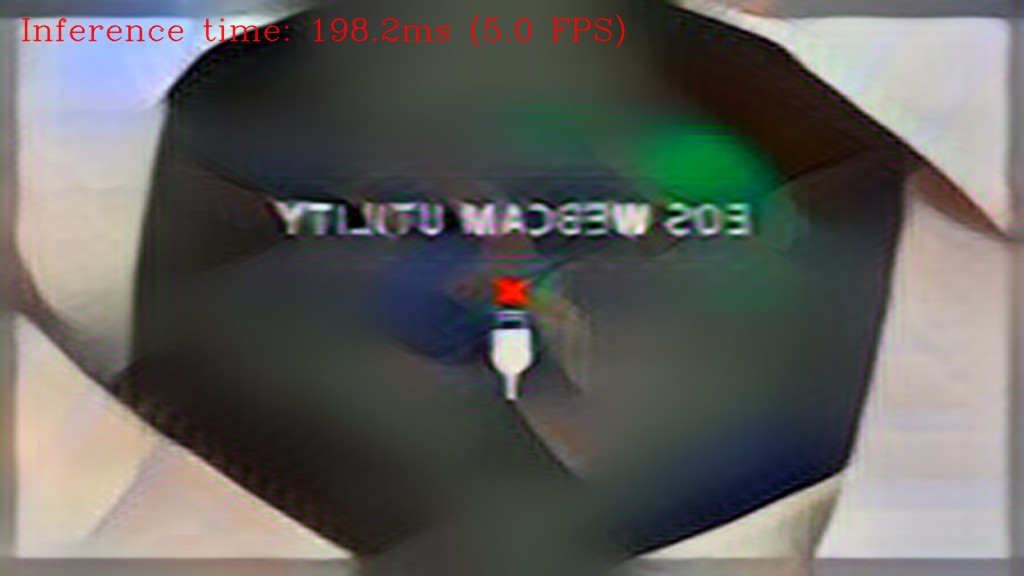

Interrupted


In [46]:
run_style_transfer(source=0, flip=True, use_popup=False)

### Run Action Recognition on a Video File

Find out how the model works in a video file. [Any format supported](https://docs.opencv.org/4.5.1/dd/d43/tutorial_py_video_display.html) by OpenCV will work. You can press the stop button anytime while the video file is running, and it will activate the webcam for the next step.

> **NOTE**: Sometimes, the video can be cut off if there are corrupted frames. In that case, you can convert it. If you experience any problems with your video, use the [HandBrake](https://handbrake.fr/) and select the MPEG format.

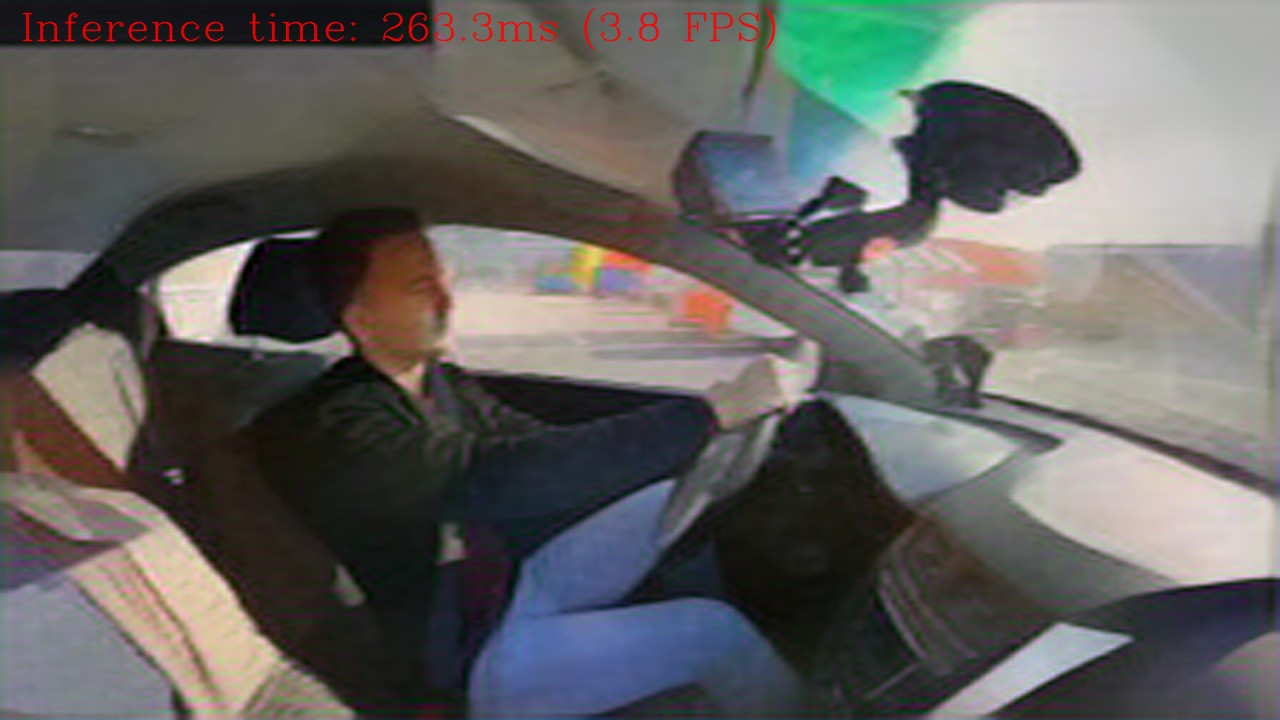

Interrupted


In [47]:
video_file = "https://github.com/intel-iot-devkit/sample-videos/blob/b8e3425998213e0b4957c20f0ed5f83411f7a802/driver-action-recognition.mp4?raw=true"
run_style_transfer(source=video_file, flip=False, use_popup=False)

## References

1. [fast-neural-style-mosaic-onnx](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/fast-neural-style-mosaic-onnx/README.md)
2. [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/)